=== Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB

=== Testing 8x8 Matrix ===
Input matrix (8x8):
tensor([[0.6130, 0.0101, 0.3984, 0.0403, 0.1563, 0.4825, 0.7362, 0.4060],
        [0.5189, 0.2867, 0.2416, 0.9228, 0.8299, 0.0342, 0.3879, 0.0824],
        [0.7742, 0.2792, 0.5138, 0.2068, 0.0074, 0.8750, 0.9682, 0.1201],
        [0.1972, 0.4503, 0.0511, 0.4892, 0.9331, 0.3807, 0.0509, 0.2663],
        [0.6495, 0.2675, 0.1733, 0.8565, 0.2761, 0.2093, 0.0711, 0.7701],
        [0.6100, 0.3444, 0.9852, 0.4692, 0.9203, 0.7127, 0.1052, 0.8138],
        [0.1092, 0.6099, 0.1751, 0.8407, 0.8705, 0.7287, 0.2541, 0.1667],
        [0.7270, 0.3987, 0.2696, 0.8030, 0.4109, 0.1475, 0.0228, 0.2331]],
       device='cuda:0')

Triton Output matrix after dropout (p=0.5):
tensor([[0.0000, 0.0201, 0.0000, 0.0000, 0.0000, 0.9649, 0.0000, 0.8120],
        [1.0378, 0.0000, 0.4832, 1.8457, 1.6598, 0.0684, 0.0000, 0.0000],
        [1.5484, 0.5584, 0.0000, 0.0000, 0.0000, 1.7501, 0.0000, 0.2

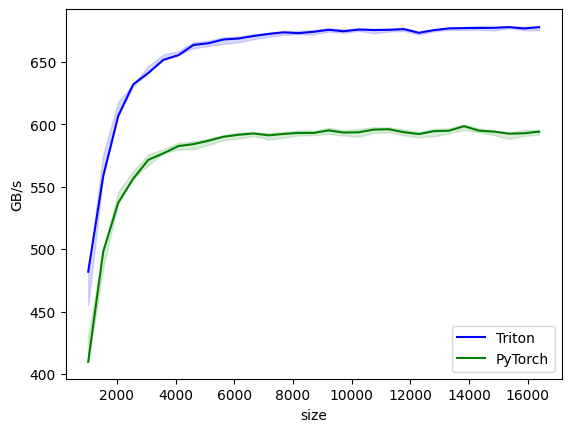

dropout-performance:
       size      Triton     PyTorch
0    1024.0  481.882344  409.600010
1    1536.0  558.545450  498.162140
2    2048.0  606.814814  537.180338
3    2560.0  632.098779  556.521727
4    3072.0  641.113029  571.534916
5    3584.0  651.636389  576.735630
6    4096.0  655.360017  582.542232
7    4608.0  663.551968  584.112658
8    5120.0  664.935091  586.819469
9    5632.0  667.946088  590.019052
10   6144.0  668.734677  591.598782
11   6656.0  670.759728  592.657511
12   7168.0  672.375203  591.175267
13   7680.0  673.684183  592.287928
14   8192.0  673.026962  593.085987
15   8704.0  674.113902  593.058097
16   9216.0  675.714849  595.113906
17   9728.0  674.569365  593.361128
18  10240.0  675.907573  593.623175
19  10752.0  675.518298  595.757249
20  11264.0  675.686437  596.050521
21  11776.0  676.274667  593.639438
22  12288.0  673.315087  592.192761
23  12800.0  675.461744  594.519249
24  13312.0  676.826212  594.821905
25  13824.0  677.093870  598.513553
26  143

In [11]:
import torch
import triton
import triton.language as tl

DEVICE = torch.device("cuda:0")

@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_COLS': 32}),
        triton.Config({'BLOCK_SIZE_COLS': 64}),
        triton.Config({'BLOCK_SIZE_COLS': 128}),
        triton.Config({'BLOCK_SIZE_COLS': 256}),
        triton.Config({'BLOCK_SIZE_COLS': 512}),
        triton.Config({'BLOCK_SIZE_COLS': 1024}),
        triton.Config({'BLOCK_SIZE_COLS': 2048}),
    ],
    key=['n_cols'],
)
@triton.jit
def dropout(
    x_ptr,
    output_ptr,
    n_rows,
    n_cols,
    p, # dropout probability
    seed,
    BLOCK_SIZE_COLS: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    row_start = pid * n_cols
    # we don't need nrows because we launch that many blocks (programs)
    for col_start in tl.range(0, n_cols, BLOCK_SIZE_COLS):
        offsets = col_start + tl.arange(0, BLOCK_SIZE_COLS)
        mask = offsets < n_cols
        mem_offsets = row_start + offsets
        x = tl.load(x_ptr + mem_offsets, mask=mask)
        random = tl.rand(seed, mem_offsets)
        dropout_mask = random > p
        output = tl.where(dropout_mask, x / (1 - p), 0.0)
        tl.store(output_ptr + mem_offsets, output, mask=mask)

def triton_dropout(x, p, seed):
    output = torch.empty_like(x)
    n_rows, n_cols = x.shape
    grid = (n_rows,)
    dropout[grid](
        x_ptr=x,
        output_ptr=output,
        n_rows=n_rows,
        n_cols=n_cols,
        p=p,
        seed=seed
    )
    return output

def torch_dropout(x, p, seed):
    torch.manual_seed(seed)
    return torch.nn.functional.dropout(x, p=p, training=True)

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[512 * i for i in range(2, 33)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'PyTorch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='dropout-performance',
        args={'p': 0.5, 'seed': 1337},
    ))
def benchmark_dropout(size, provider, p, seed):
    x = torch.rand(size, size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch_dropout(x, p, seed), quantiles=quantiles
        )
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_dropout(x, p, seed), quantiles=quantiles
        )
    # 计算带宽: 2 * size (读输入 + 写输出) * element_size
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

def test_triton_dropout_8x8():
    torch.manual_seed(42)
    x = torch.rand(8, 8, device=DEVICE, dtype=torch.float32)
    print("Input matrix (8x8):")
    print(x)
    p = 0.5
    seed = 233243
    output = triton_dropout(x, p, seed)
    print(f"\nTriton Output matrix after dropout (p={p}):")
    print(output)
    torch_output = torch_dropout(x, p, seed)
    print(f"\nPyTorch Output matrix after dropout (p={p}):")
    print(torch_output)
    triton_zeros = (output == 0).sum().item()
    torch_zeros = (torch_output == 0).sum().item()
    total_elements = output.numel()
    print(f"\nStatistics:")
    print(f"Total elements: {total_elements}")
    print(f"Triton zeros (dropped): {triton_zeros} ({triton_zeros/total_elements:.2%})")
    print(f"PyTorch zeros (dropped): {torch_zeros} ({torch_zeros/total_elements:.2%})")
    print(f"Expected dropout rate: {p:.2%}")

if __name__ == "__main__":
    print("=== Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print("Name:", specs.name)
    print("SM Count:", specs.multi_processor_count)
    print("Device Memory:", specs.total_memory // (1024 ** 2), "MB")
    print("\n=== Testing 8x8 Matrix ===")
    test_triton_dropout_8x8()
    print("\n=== Running Benchmark ===")
    benchmark_dropout.run(show_plots=True, print_data=True)